In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler, PowerTransformer, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")

from scipy import stats
from math import sqrt

In [2]:
# ==========================================================
df = pd.read_csv("yield.csv")

print(df.head())
print("Shape:", df.shape)
print("\nMissing values:\n", df.isnull().sum())
print("\nData types:\n", df.dtypes)
print("\nDescribe:\n", df.describe())

  Domain Code Domain  Area Code         Area  Element Code Element  Item Code  \
0          QC  Crops          2  Afghanistan          5419   Yield         56   
1          QC  Crops          2  Afghanistan          5419   Yield         56   
2          QC  Crops          2  Afghanistan          5419   Yield         56   
3          QC  Crops          2  Afghanistan          5419   Yield         56   
4          QC  Crops          2  Afghanistan          5419   Yield         56   

    Item  Year Code  Year   Unit  Value  
0  Maize       1961  1961  hg/ha  14000  
1  Maize       1962  1962  hg/ha  14000  
2  Maize       1963  1963  hg/ha  14260  
3  Maize       1964  1964  hg/ha  14257  
4  Maize       1965  1965  hg/ha  14400  
Shape: (56717, 12)

Missing values:
 Domain Code     0
Domain          0
Area Code       0
Area            0
Element Code    0
Element         0
Item Code       0
Item            0
Year Code       0
Year            0
Unit            0
Value           0
dtype: i

In [3]:
cat_cols = df.select_dtypes(include='object').columns
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])
print("\nAfter encoding:\n", df.head())



After encoding:
    Domain Code  Domain  Area Code  Area  Element Code  Element  Item Code  \
0            0       0          2     0          5419        0         56   
1            0       0          2     0          5419        0         56   
2            0       0          2     0          5419        0         56   
3            0       0          2     0          5419        0         56   
4            0       0          2     0          5419        0         56   

   Item  Year Code  Year  Unit  Value  
0     1       1961  1961     0  14000  
1     1       1962  1962     0  14000  
2     1       1963  1963     0  14260  
3     1       1964  1964     0  14257  
4     1       1965  1965     0  14400  



Skewness Before and After:
                 Before     After
Domain Code   0.000000  0.000000
Domain        0.000000  0.000000
Area Code     0.189455 -0.218242
Area          0.060342 -0.247861
Element Code  0.000000  0.000000
Element       0.000000  0.000000
Item Code     2.371168 -0.007233
Item          0.083739 -0.185560
Year Code    -0.098916 -0.027210
Year         -0.098916 -0.027210
Unit          0.000000  0.000000
Value         2.205183 -0.004310


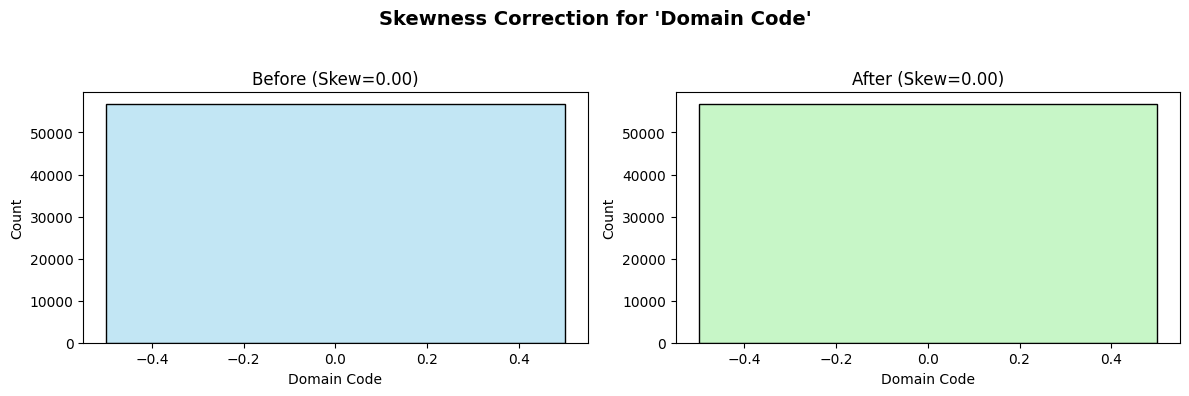

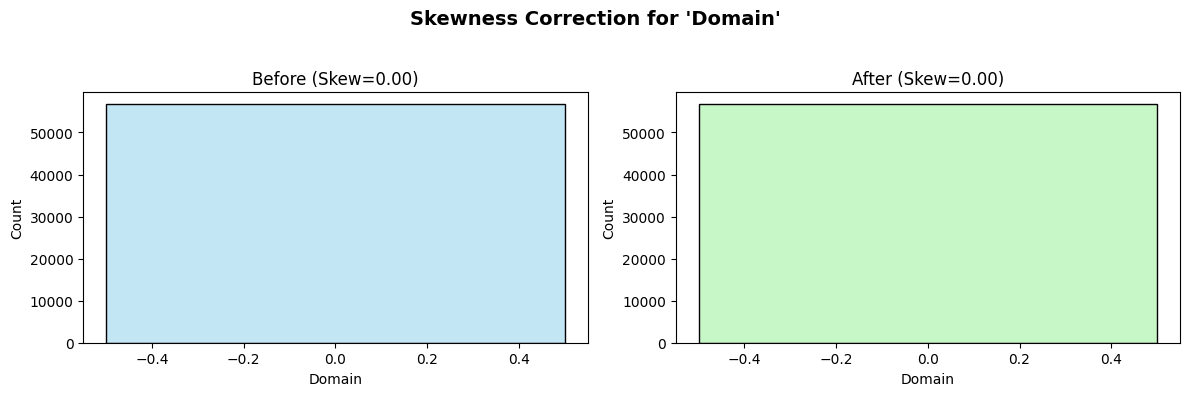

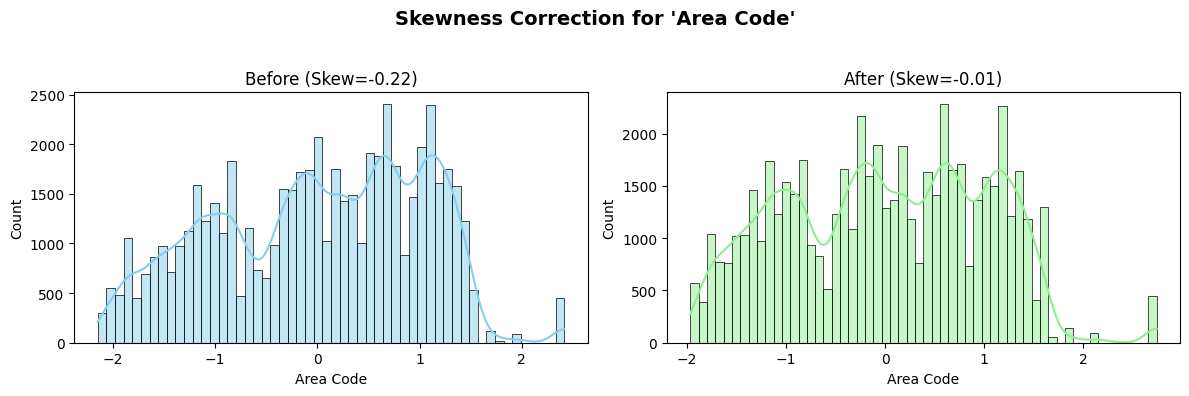

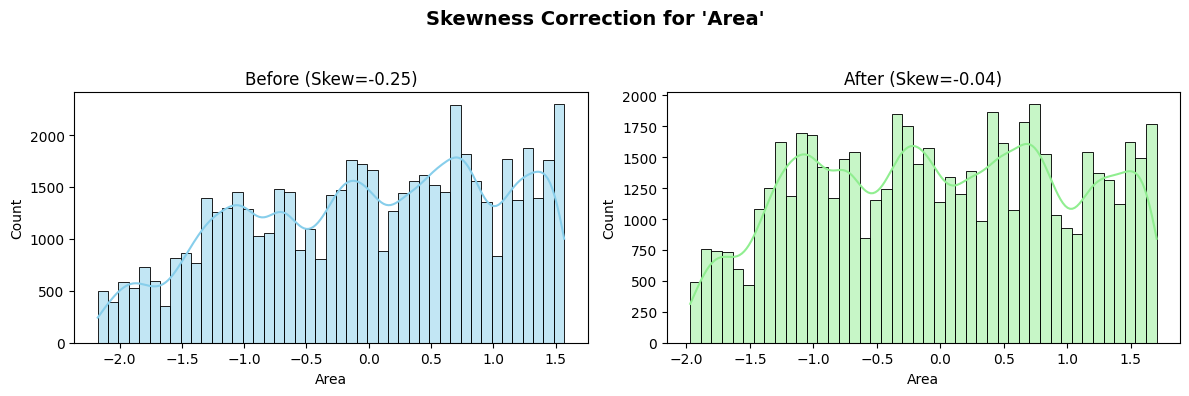

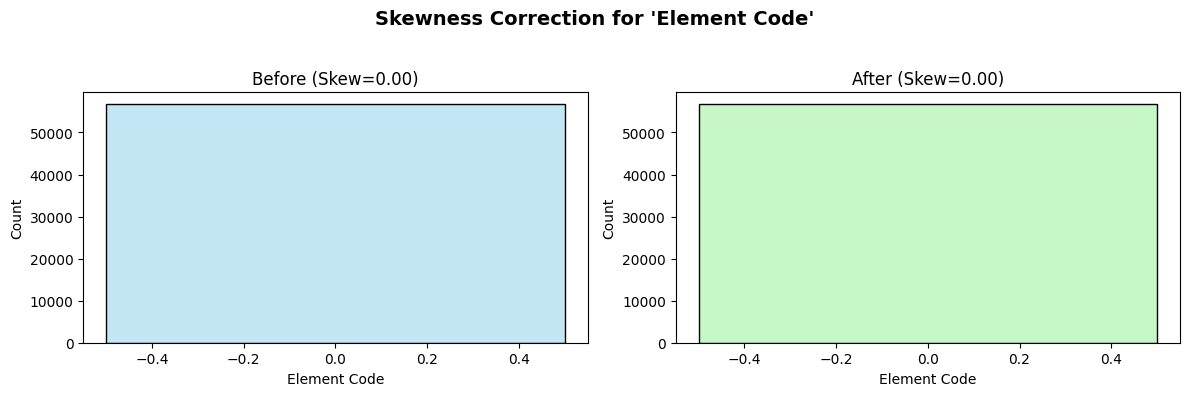

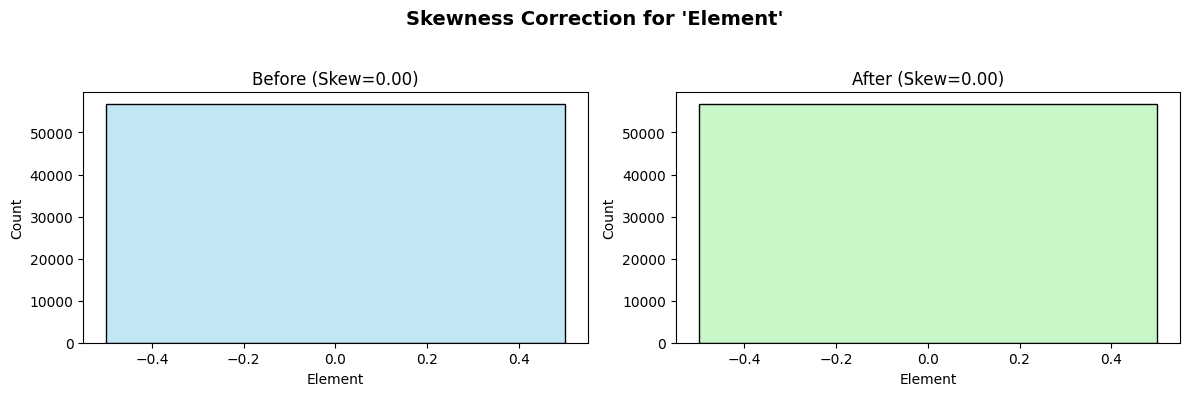

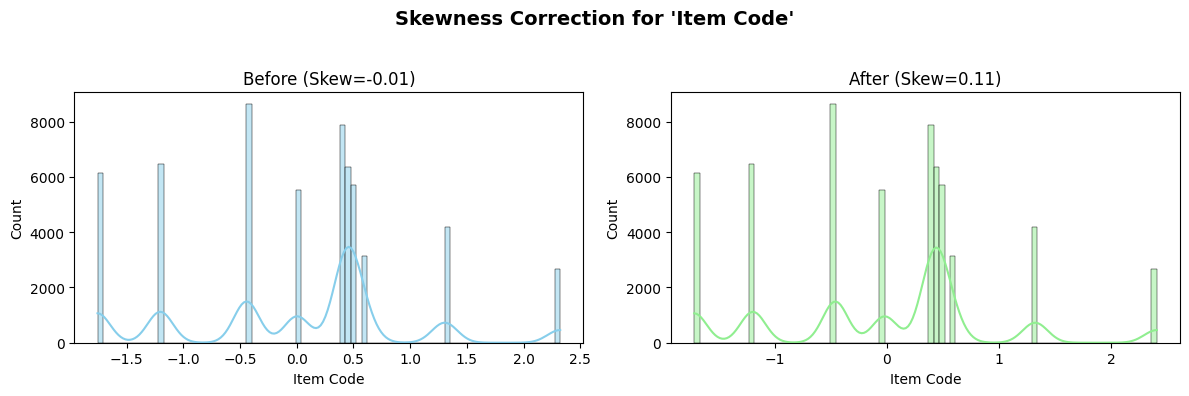

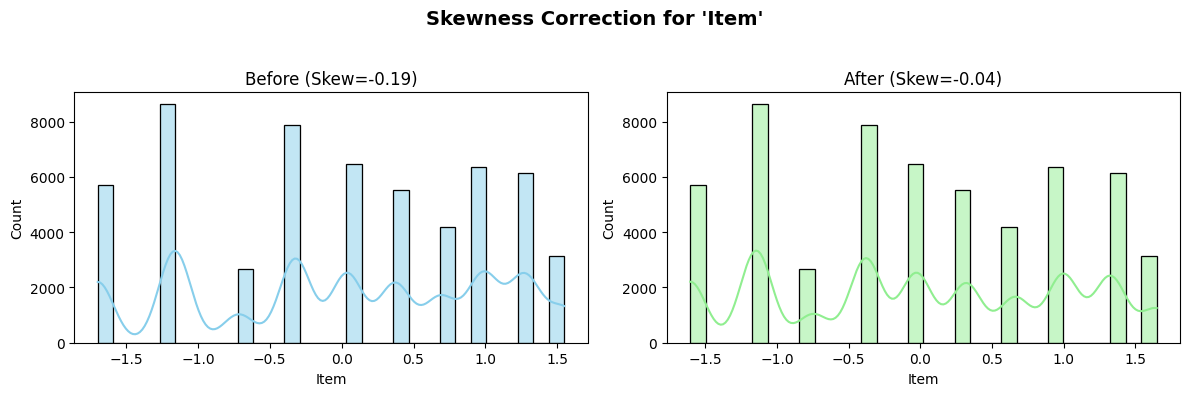

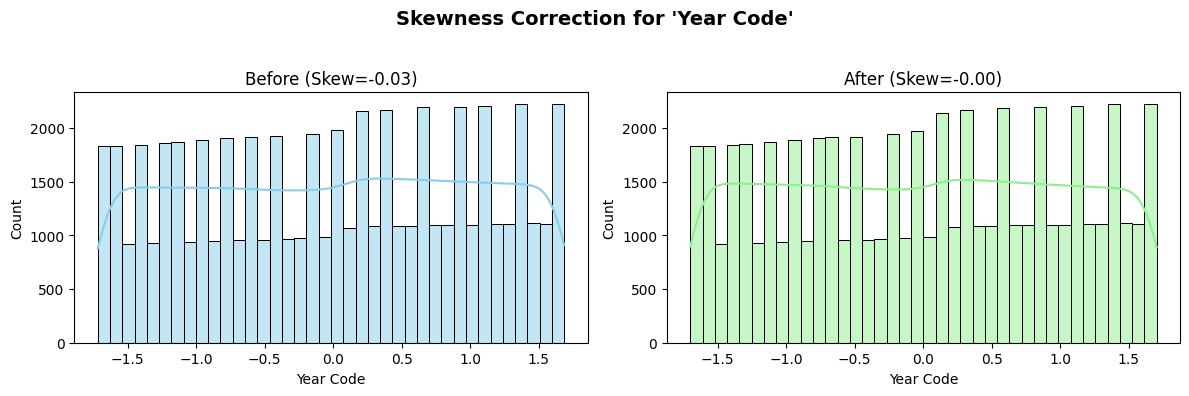

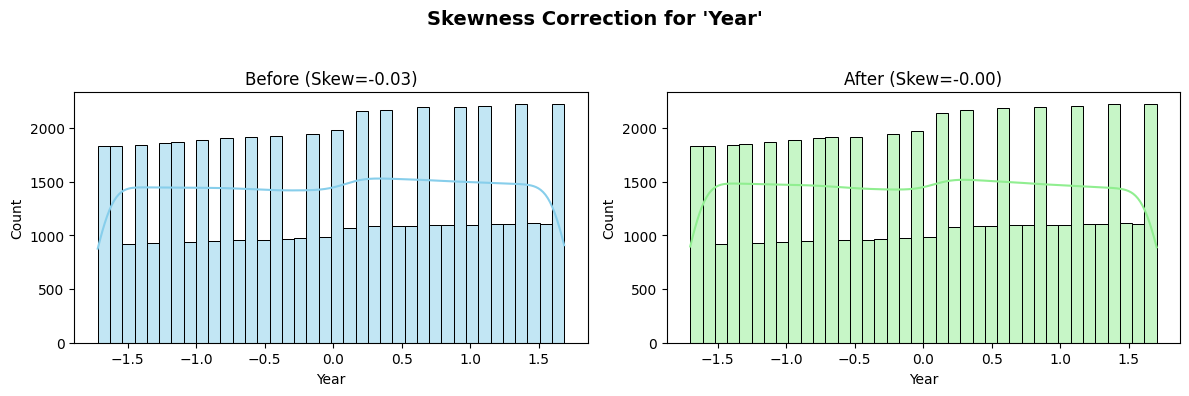

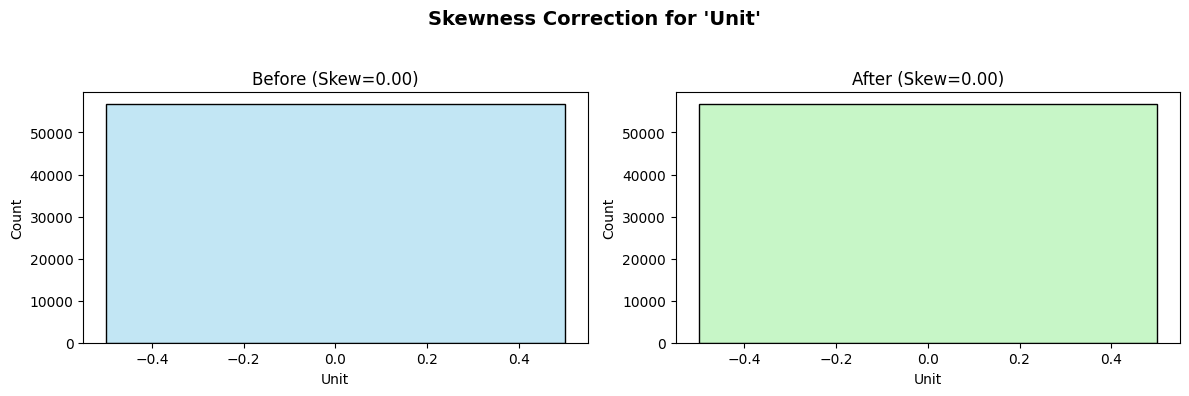

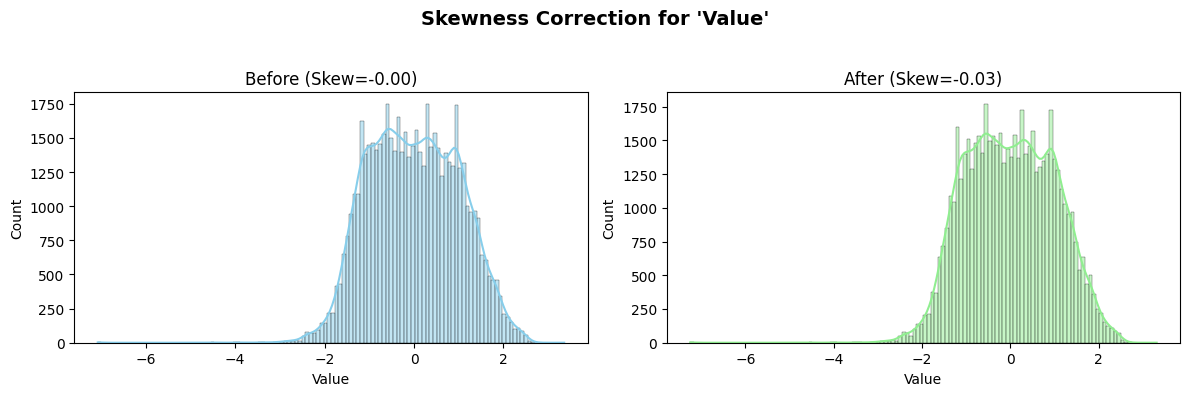

In [4]:
num_cols = df.select_dtypes(include=np.number).columns
skew_before = df[num_cols].skew()

scaler = PowerTransformer(method='yeo-johnson')
df[num_cols] = scaler.fit_transform(df[num_cols])

skew_after = pd.DataFrame({'Before': skew_before, 'After': df[num_cols].skew()})
print("\nSkewness Before and After:\n", skew_after)

num_cols = df.select_dtypes(include=[np.number]).columns
num_cols = df.select_dtypes(include=[np.number]).columns

# ======== Apply Yeo–Johnson Transformation ========
pt = PowerTransformer(method='yeo-johnson')
df_trans = df.copy()
df_trans[num_cols] = pt.fit_transform(df[num_cols])

for col in num_cols:
    plt.figure(figsize=(12, 4))
    plt.suptitle(f"Skewness Correction for '{col}'", fontsize=14, fontweight='bold')
    
    # Before
    plt.subplot(1, 2, 1)
    sns.histplot(df[col], kde=True, color='skyblue')
    plt.title(f"Before (Skew={df[col].skew():.2f})")
    
    # After
    plt.subplot(1, 2, 2)
    sns.histplot(df_trans[col], kde=True, color='lightgreen')
    plt.title(f"After (Skew={df_trans[col].skew():.2f})")
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [5]:
outlier_count = {}
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    outliers = ((df[col] < lower) | (df[col] > upper)).sum()
    outlier_count[col] = outliers
    df[col] = np.where((df[col] < lower) | (df[col] > upper), 0, df[col])
print("\nOutlier counts:\n", outlier_count)


Outlier counts:
 {'Domain Code': np.int64(0), 'Domain': np.int64(0), 'Area Code': np.int64(0), 'Area': np.int64(0), 'Element Code': np.int64(0), 'Element': np.int64(0), 'Item Code': np.int64(2654), 'Item': np.int64(0), 'Year Code': np.int64(0), 'Year': np.int64(0), 'Unit': np.int64(0), 'Value': np.int64(30)}


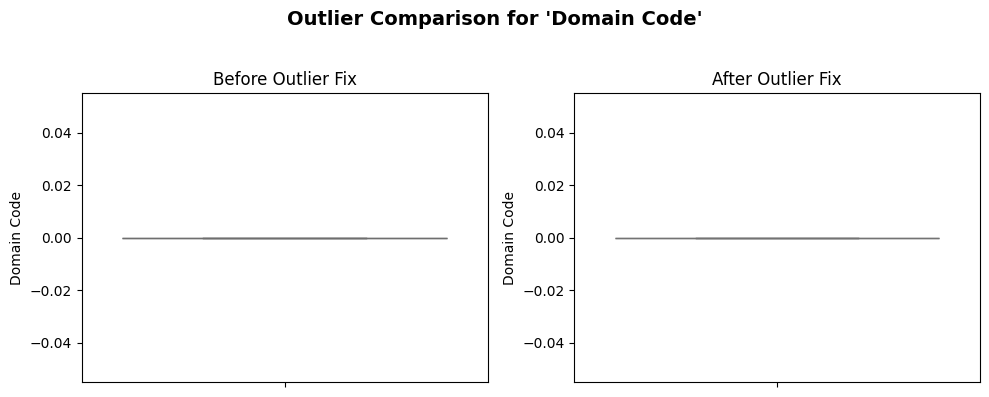

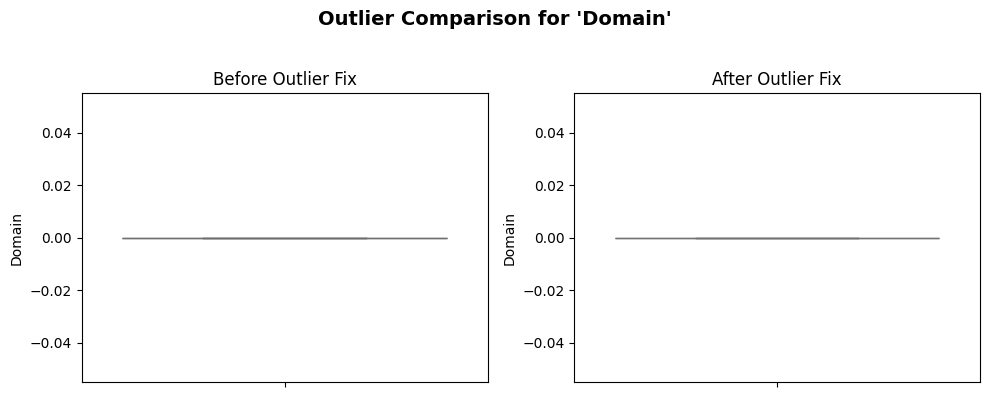

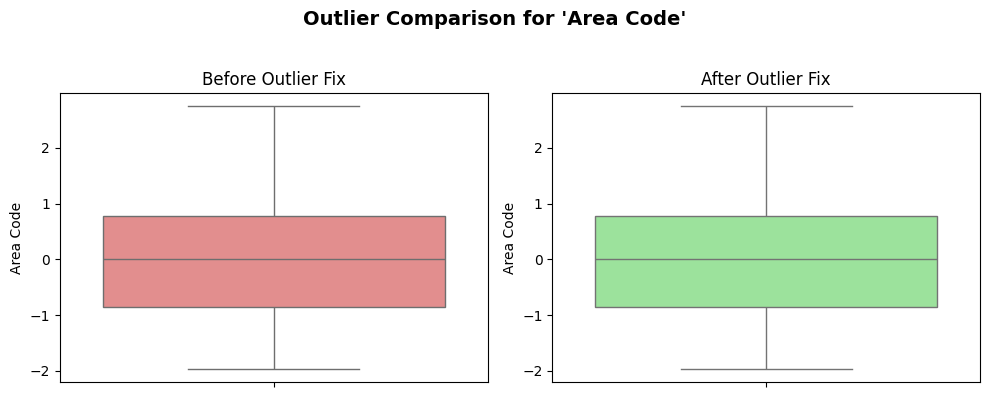

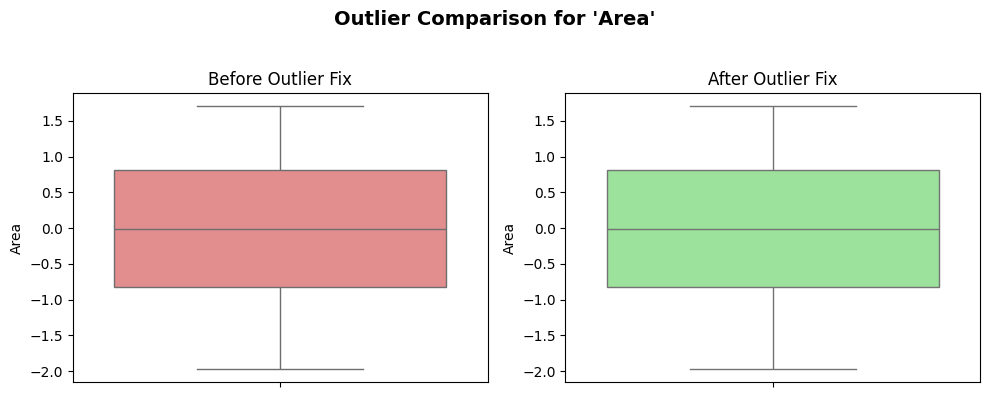

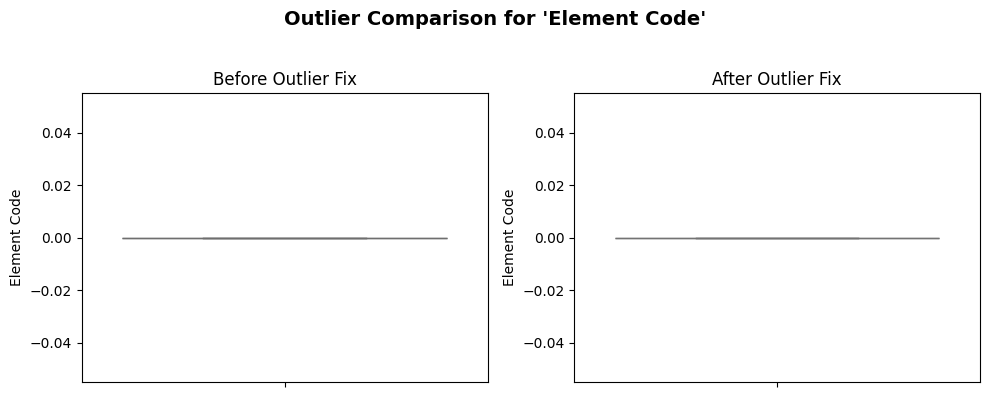

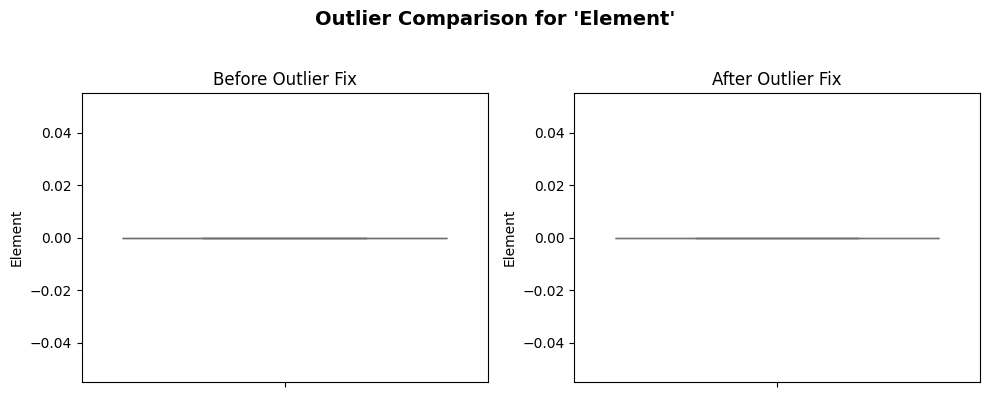

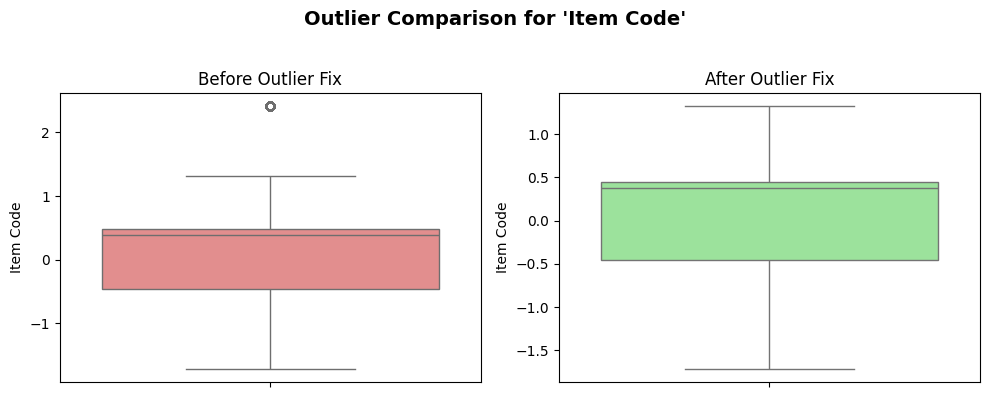

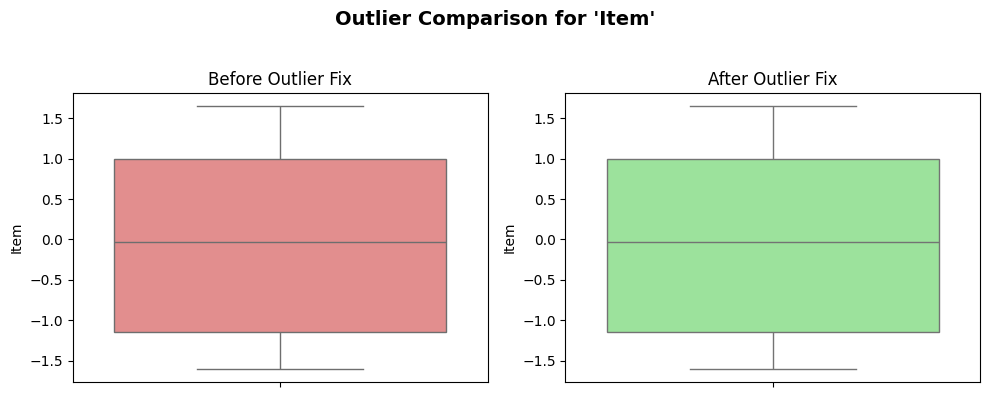

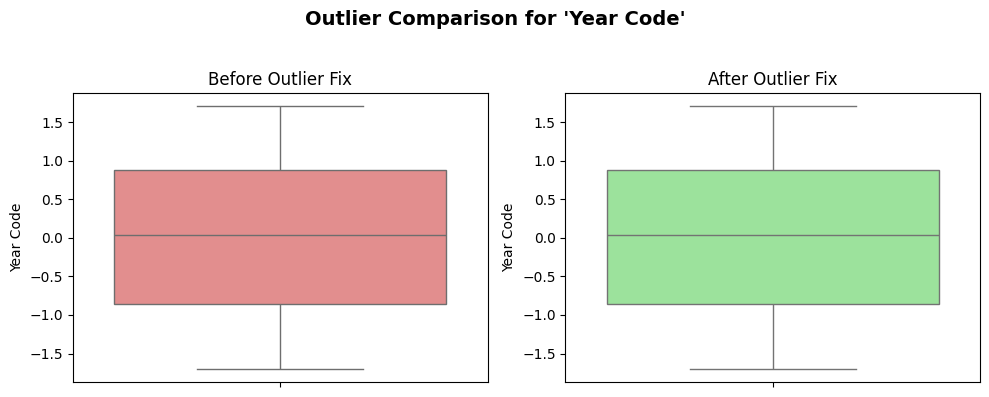

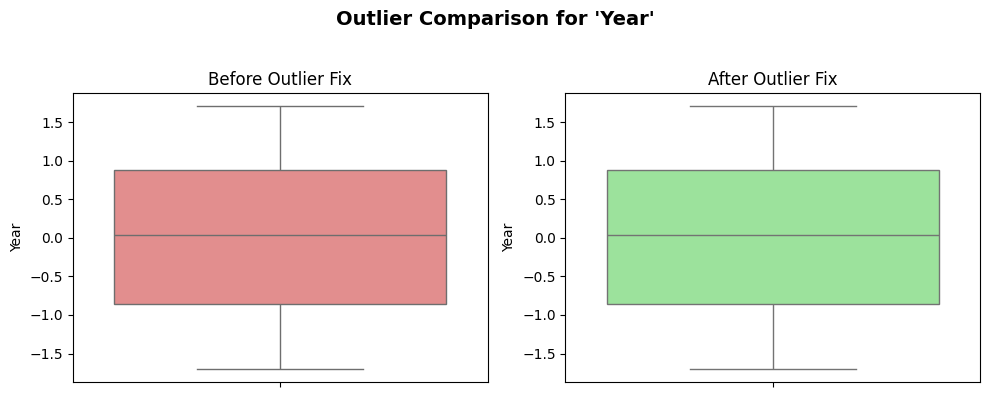

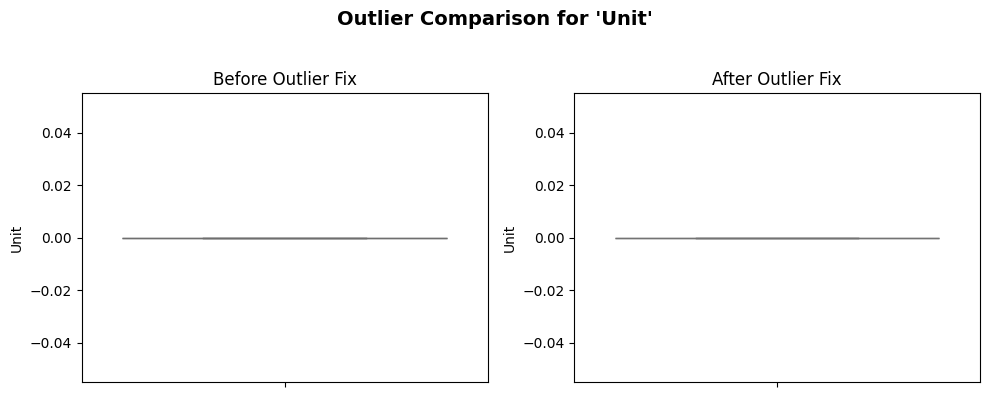

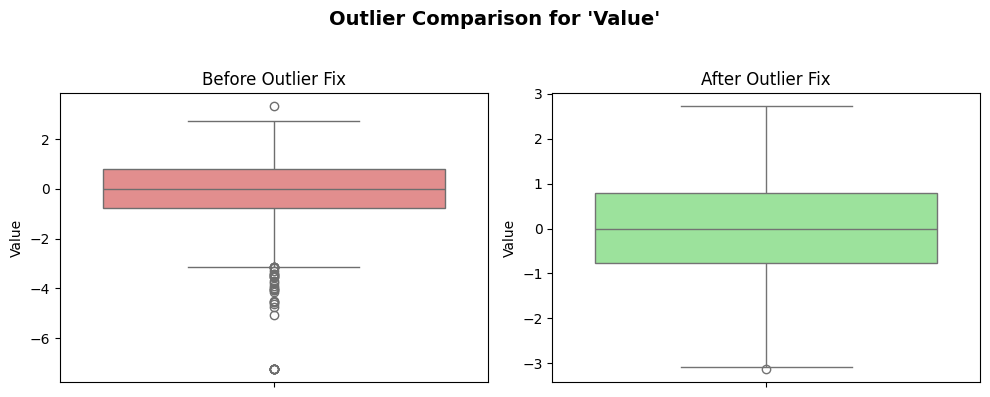

In [6]:

# ======== Detect and fix outliers using IQR, then plot ========
df_out = df_trans.copy()

for col in num_cols:
    Q1 = df_out[col].quantile(0.25)
    Q3 = df_out[col].quantile(0.75)
    IQR = Q3 - Q1
    low = Q1 - 1.5 * IQR
    high = Q3 + 1.5 * IQR

    mask = (df_out[col] < low) | (df_out[col] > high)
    df_out.loc[mask, col] = df_out[col].median()

    plt.figure(figsize=(10, 4))
    plt.suptitle(f"Outlier Comparison for '{col}'", fontsize=14, fontweight='bold')

    # Before outlier handling
    plt.subplot(1, 2, 1)
    sns.boxplot(y=df_trans[col], color='lightcoral')
    plt.title("Before Outlier Fix")

    # After outlier handling
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df_out[col], color='lightgreen')
    plt.title("After Outlier Fix")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [7]:
X = df.drop('Value', axis=1)
y = df['Value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
target_col = "Value"
X = df.drop(columns=[target_col])
y = df[target_col]

In [9]:
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

In [10]:
# ========== 1️⃣ Regression Models ==========
reg_results = []

# Simple Linear Regression (single most correlated feature)
corrs = df.corr()[target_col].abs().sort_values(ascending=False)
top_feat = corrs.index[1]
lr_simple = LinearRegression().fit(X[[top_feat]], y)
yp = lr_simple.predict(X[[top_feat]])
reg_results.append({"Model": f"Linear_Simple ({top_feat})",
                    "R2": r2_score(y, yp), "MSE": mean_squared_error(y, yp)})

# Multiple Linear Regression
lr_multi = LinearRegression().fit(X, y)
yp = lr_multi.predict(X)
reg_results.append({"Model": "Linear_Multiple",
                    "R2": r2_score(y, yp), "MSE": mean_squared_error(y, yp)})

# Ridge
ridge = Ridge(alpha=1.0).fit(X, y)
yp = ridge.predict(X)
reg_results.append({"Model": "Ridge", "R2": r2_score(y, yp), "MSE": mean_squared_error(y, yp)})

# Lasso
lasso = Lasso(alpha=0.1).fit(X, y)
yp = lasso.predict(X)
reg_results.append({"Model": "Lasso", "R2": r2_score(y, yp), "MSE": mean_squared_error(y, yp)})

# Polynomial Regression (degree=2)
pf = PolynomialFeatures(degree=2, include_bias=False)
X_poly = pf.fit_transform(X_scaled)
poly_lr = LinearRegression().fit(X_poly, y)
yp = poly_lr.predict(X_poly)
reg_results.append({"Model": "Polynomial(deg=2)", "R2": r2_score(y, yp), "MSE": mean_squared_error(y, yp)})

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42).fit(X, y)
yp = rf.predict(X)
reg_results.append({"Model": "RandomForestRegressor", "R2": r2_score(y, yp), "MSE": mean_squared_error(y, yp)})

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=100, random_state=42).fit(X, y)
yp = gbr.predict(X)
reg_results.append({"Model": "GradientBoostingRegressor", "R2": r2_score(y, yp), "MSE": mean_squared_error(y, yp)})

print("\n=== Regression Results ===")
print(pd.DataFrame(reg_results).to_string(index=False, float_format="%.4f"))



=== Regression Results ===
                    Model     R2    MSE
Linear_Simple (Item Code) 0.0854 0.9027
          Linear_Multiple 0.1179 0.8705
                    Ridge 0.1179 0.8705
                    Lasso 0.0856 0.9025
        Polynomial(deg=2) 0.2657 0.7247
    RandomForestRegressor 0.9963 0.0037
GradientBoostingRegressor 0.6862 0.3097


In [11]:
# ========== 2️⃣ Classification Models ==========
y_class = (y > y.median()).astype(int)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_scaled, y_class, test_size=0.2, random_state=42, stratify=y_class)

def eval_classification(model, name):
    model.fit(X_train_c, y_train_c)
    y_pred = model.predict(X_test_c)
    return {
        'Model': name,
        'Accuracy': accuracy_score(y_test_c, y_pred),
        'Precision': precision_score(y_test_c, y_pred),
        'Recall': recall_score(y_test_c, y_pred),
        'F1-score': f1_score(y_test_c, y_pred)
    }

models_class = [
    (LogisticRegression(max_iter=1000), "Logistic Regression"),
    (KNeighborsClassifier(n_neighbors=5), "KNN"),
    (SVC(), "SVM"),
    (DecisionTreeClassifier(random_state=42), "Decision Tree"),
    (RandomForestClassifier(n_estimators=100, random_state=42), "Random Forest"),
    (GaussianNB(), "Naive Bayes"),
    (AdaBoostClassifier(n_estimators=100, random_state=42), "AdaBoost"),
    (GradientBoostingClassifier(n_estimators=100, random_state=42), "GradientBoosting")
]

# Optional XGBoost
try:
    import xgboost as xgb
    models_class.append((xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), "XGBoost"))
except:
    print("XGBoost not installed, skipping.")

clf_results = [eval_classification(m, n) for m, n in models_class]
clf_df = pd.DataFrame(clf_results).sort_values(by="Accuracy", ascending=False)

print("\n=== Classification Results ===")
print(clf_df.to_string(index=False, float_format="%.4f"))



=== Classification Results ===
              Model  Accuracy  Precision  Recall  F1-score
      Decision Tree    0.9682     0.9679  0.9684    0.9682
            XGBoost    0.9565     0.9552  0.9579    0.9565
      Random Forest    0.9193     0.9231  0.9147    0.9189
                KNN    0.8635     0.8608  0.8672    0.8640
   GradientBoosting    0.8573     0.8728  0.8364    0.8542
                SVM    0.8415     0.8712  0.8014    0.8349
           AdaBoost    0.8411     0.8742  0.7967    0.8337
        Naive Bayes    0.6847     0.6399  0.8443    0.7280
Logistic Regression    0.6769     0.6498  0.7671    0.7036



--- PCA Explained Variance Ratio ---
[0.3339 0.2972]
Cumulative Variance: 0.6311


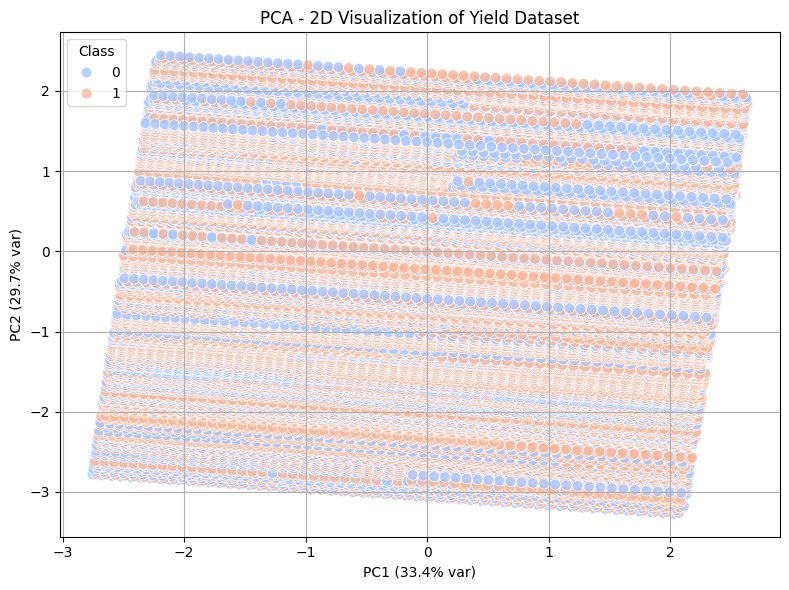

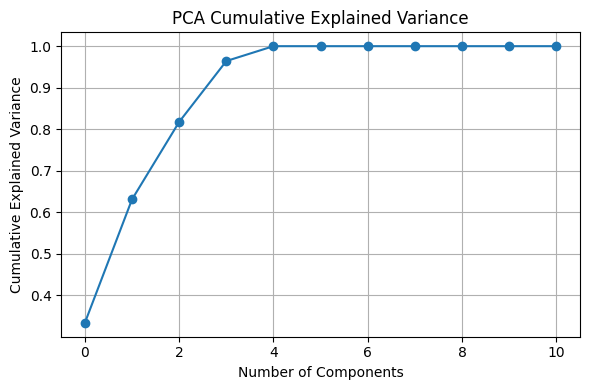

In [12]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# ====== Standardize Data ======
X_clust = StandardScaler().fit_transform(X)  # use your numeric feature matrix X

# ====== PCA ======
pca = PCA(n_components=2)  # reduce to 2D for visualization
X_pca = pca.fit_transform(X_clust)

# ====== Explained Variance ======
print("\n--- PCA Explained Variance Ratio ---")
print(np.round(pca.explained_variance_ratio_, 4))
print("Cumulative Variance:", np.round(np.sum(pca.explained_variance_ratio_), 4))

# ====== Plot PCA Scatter ======
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=y_class,         # color by classification target
    palette="coolwarm",
    s=60,
    alpha=0.8
)
plt.title("PCA - 2D Visualization of Yield Dataset")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.legend(title="Class", loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

# ====== Optional: Cumulative Variance Plot ======
plt.figure(figsize=(6, 4))
pca_full = PCA().fit(X_clust)
cum_var = np.cumsum(pca_full.explained_variance_ratio_)
plt.plot(cum_var, marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Cumulative Explained Variance")
plt.grid(True)
plt.tight_layout()
plt.show()
